# Volatility Surface Construction – Notebook 4
## The SABR Stochastic Volatility Model

### 4.1 Introduction to the model

This notebook works with the **Stochastic Alpha, Beta, Rho (SABR)** model, a dynamic framework widely used in quantitative finance to manage volatility smiles. Unlike the SVI model, which is a static parametric fit, SABR is derived from stochastic differential equations describing the joint evolution of the forward price and its volatility.

The analysis focuses on the **Hagan (2002)** implied volatility approximation, which allows for the direct calibration of SABR parameters to market observables. The structural implementation of the model is examined via the `src/sabr.py` module, followed by a controlled numerical illustration of the model's behavior.

### 4.2 Motivation: Why SABR?

In the previous notebook, the SVI model was introduced as a robust, geometric tool for fitting implied volatility slices. While SVI is excellent for interpolation, it lacks a direct link to the underlying asset's dynamics.

The SABR model fills this gap. Developed by Hagan, Kumar, Lesniewski, and Woodward, it assumes that volatility itself is a random process. This stochastic foundation provides two distinct advantages:

1.  **Dynamic Consistency:** It predicts how the volatility smile should evolve as the spot price changes.
2.  **Intuitive Parameters:** Its parameters map directly to market phenomena: the level of volatility, the skew (correlation), and the volatility-of-volatility (curvature).

For these reasons, SABR is the industry standard for interest rate swaptions and is frequently adapted for equity and FX markets.

### 4.3 The SABR Model: Intuition & Dynamics

The SABR model posits that the forward price $F_t$ and its instantaneous volatility $\alpha_t$ evolve according to a system of stochastic differential equations (SDEs):

$$ dF_t = \alpha_t F_t^\beta dW_t^1 $$
$$ d\alpha_t = \nu \alpha_t dW_t^2 $$

where the two Brownian motions are correlated: $d\langle W^1, W^2 \rangle_t = \rho dt$.

**Economic Interpretation:**
* **Price Diffusion:** The asset price moves with a volatility that depends on its current level ($F^\beta$) and a stochastic amplitude ($\alpha_t$).
* **Stochastic Volatility:** The volatility parameter $\alpha_t$ is not constant; it drifts and diffuses over time, driven by the "vol-of-vol" parameter $\nu$.
* **Correlation:** When $\rho < 0$, a drop in price is associated with a rise in volatility (the leverage effect), creating a downward sloping skew.

### 4.4 From Dynamics to Implied Volatility

Solving the SABR SDEs for exact option prices is computationally expensive (requiring Finite Difference methods or Monte Carlo). However, Hagan et al. derived an asymptotic expansion that approximates the Black-Scholes implied volatility $\sigma_{imp}(K, F)$ directly. This is the model's greatest strength: it provides a closed-form algebraic mapping from model parameters to the implied volatility surface. The approximation is constructed in three steps: 
1. The Distance Variable ($z$): First, we normalize the distance between the strike and forward price, adjusted for the volatility of volatility:$$z = \frac{\nu}{\alpha} (FK)^{\frac{1-\beta}{2}} \ln\left(\frac{F}{K}\right)$$
2. The Skew Function $\chi(z)$: Next, we transform $z$ to capture the skew using the correlation parameter $\rho$:$$\chi(z) = \ln\left( \frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{1 - \rho} \right)$$
3. The Full Expansion: Finally, the implied volatility is given by combining the volatility level, the skew adjustment, and a time-dependent correction factor:$$\sigma_{imp}(K, F) \approx \frac{\alpha}{(FK)^{\frac{1-\beta}{2}} \left[ 1 + \frac{(1-\beta)^2}{24} \ln^2\left(\frac{F}{K}\right) + \dots \right]} \cdot \left(\frac{z}{\chi(z)}\right) \cdot \left[ 1 + \left( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(FK)^{1-\beta}} + \frac{1}{4} \frac{\rho \beta \nu \alpha}{(FK)^{\frac{1-\beta}{2}}} + \frac{2-3\rho^2}{24} \nu^2 \right) T \right]$$This explicit formula allows us to fit the complex stochastic model to market data using standard least-squares optimization, bypassing the need for heavy simulations.

### 4.5 SABR Parameters and Their Meaning

The Hagan approximation relies on four key parameters. Understanding their independent effects is crucial for calibration stability.

* **$\alpha$ (Alpha) — Volatility Level:**
    Controls the overall height of the ATM volatility. An increase in $\alpha$ shifts the entire smile upward in a parallel fashion.

* **$\beta$ (Beta) — CEV Elasticity:**
    Controls the relationship between spot price and volalitility. 
    * $\beta = 1$: Lognormal (Flat)
    * $\beta = 0$: Normal (Stochastic)
    * In equity markets, $\beta$ is often fixed to 1 or 0.5 to reduce parameter redundancy, as its effect on the smile shape is often indistinguishable from $\rho$ for short maturities.

* **$\rho$ (Rho) — Correlation:**
    Controls the **rotation** or skew of the smile.
    * $\rho < 0$: Downward slope (typical for Equities).
    * $\rho > 0$: Upward slope (typical for some Commodities/FX).

* **$\nu$ (Nu) — Volatility of Volatility:**
    Controls the **curvature** or convexity of the smile. A higher $\nu$ lifts the wings (OTM puts and calls) relative to the ATM point, making the smile more "U-shaped".

### 4.6 Design Philosophy: `src/sabr.py`

The implementation in `src/sabr.py` adheres to the principle of "separation of concerns." It is a pure logic module that:
1.  **Encapsulates** the complex Hagan approximation formula.
2.  **Validates** input parameters to prevent numerical explosions.
3.  **Vectorizes** calculations to handle full option chains efficiently.

### 4.7 Implementation Walkthrough

The module consists of three logical blocks:

**1. Parameter Validation (`_check_sabr_parameters`)**
Ensures mathematical constraints are met:
* $\alpha > 0$, $\nu > 0$
* $|\rho| < 1$ (Correlation bounds)
* $0 \leq \beta \leq 1$

**2. The Hagan Formula (`hagan_log_normal_vol`)**
This is the core engine. It handles the asymptotic expansion involving the variable $z$ and the function $\chi(z)$.
* *ATM Handling:* The formula has a singularity when $F=K$ (At-The-Money). The code explicitly handles this edge case using limits to ensure numerical stability.

**3. Public Interface (`sabr_implied_vol`)**
A clean wrapper that exposes the functionality to external scripts. It aligns with the function signature expected by the calibration engine in the next notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Ensure local modules can be imported
sys.path.append(str(Path.cwd().parent))

from src.SABR import sabr_implied_vol

### 4.8 Illustrative SABR Smiles

To visualize the model's behavior, we generate theoretical volatility smiles using the `sabr_implied_vol` function. We fix the Forward price ($F=100$) and Maturity ($T=1.0$) and vary the correlation ($\rho$) and vol-of-vol ($\nu$) to observe their impact on the curve shape.

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matte\AppData\Local\Temp\ipykernel_30552\2092304522.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Implied Volatility ($\sigma_{imp}$)")


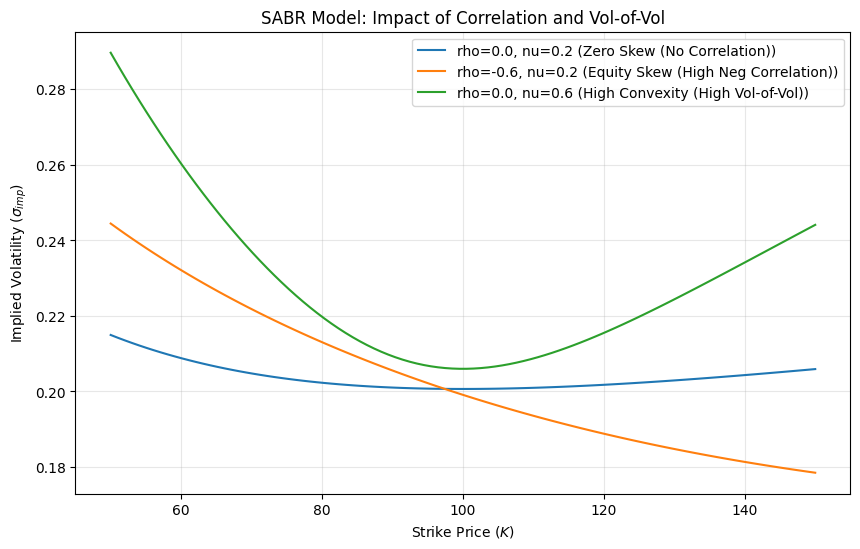

In [3]:
# Simulation Grid
K_grid = np.linspace(50, 150, 100)
F = 100.0
T = 1.0

# Baseline Parameters (Equity-like)
alpha = 0.2
beta = 1.0  # Log-normal fixed

# Scenarios
scenarios = [
    {"rho": 0.0, "nu": 0.2, "label": "Zero Skew (No Correlation)"},
    {"rho": -0.6, "nu": 0.2, "label": "Equity Skew (High Neg Correlation)"},
    {"rho": 0.0, "nu": 0.6, "label": "High Convexity (High Vol-of-Vol)"}
]

plt.figure(figsize=(10, 6))

for s in scenarios:
    iv = sabr_implied_vol(F, K_grid, T, alpha, beta, s["rho"], s["nu"])
    plt.plot(K_grid, iv, label=f"rho={s['rho']}, nu={s['nu']} ({s['label']})")

plt.title("SABR Model: Impact of Correlation and Vol-of-Vol")
plt.xlabel("Strike Price ($K$)")
plt.ylabel("Implied Volatility ($\sigma_{imp}$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.9 Strengths and Limitations

**Strengths:**
* **Interpretability:** Traders can intuit the impact of changing $\rho$ or $\nu$ in real-time.
* **Parsimony:** It captures complex smile shapes with only 3 active parameters (fixing $\beta$).
* **Market Standard:** Its ubiquity facilitates communication between counterparties.

**Limitations:**
* **Approximation Error:** The Hagan formula breaks down for very long maturities or extremely low/negative rates (though shifted SABR handles the latter).
* **Arbitrage:** Like SVI, unconstrained SABR parameters can produce negative probability densities (arbitrage) in the wings.
* **Parameter Instability:** $\rho$ and $\nu$ can be highly correlated during calibration, leading to multiple local minima.

### 4.10 Conclusion & Transition

This notebook has established the theoretical and computational foundation of the SABR model. We have explored how its stochastic dynamics translate into implied volatility shapes via the Hagan approximation and verified the implementation in `src/sabr.py`.

**Next Steps:**
In **Notebook 5**, we will move from theory to practice. We will combine the data prepared in Notebook 1 with the SVI (Notebook 3) and SABR (Notebook 4) models to perform a full **Calibration**, minimizing the error between model-implied volatilities and market observations.